In [1]:
%matplotlib inline
import grale.lenses as lenses
import grale.feedback as feedback
import grale.renderers as renderers
import grale.plotutil as plotutil
import grale.cosmology as cosmology
import grale.inversion as inversion
import grale.images as images
from grale.constants import *
import matplotlib.pyplot as plt
import numpy as np
import hashlib

renderers.setDefaultLensPlaneRenderer("threads")
renderers.setDefaultMassRenderer("threads")
feedback.setDefaultFeedback("none")

plotutil.setDefaultAngularUnit(ANGLE_ARCSEC)

cosm = cosmology.Cosmology(0.7, 0.3, 0, 0.7)
cosmology.setDefaultCosmology(cosm)

In [2]:
lens = lenses.GravitationalLens.load("model.lensdata")
zd, zs = 0.33, 4.92
sigmaCrit = lens.getCriticalDensity(cosm.getAngularDiameterDistance(zs), cosm.getAngularDiameterDistance(zd, zs))

In [3]:
imgList = [
    { "fn": "source1a.imgdata", "z": 4.92},
    { "fn": "source1b.imgdata", "z": 4.92},
    { "fn": "source1c.imgdata", "z": 4.92},
    { "fn": "source2.imgdata", "z": 3.42},
    { "fn": "source3.imgdata", "z": 2.04},
    { "fn": "source4.imgdata", "z": 2.22},
    { "fn": "source5.imgdata", "z": 2.02},
    { "fn": "source8.imgdata", "z": 2.2},
]

for i in imgList:
    i["imgdata"] = images.ImagesData.load(i["fn"])

In [4]:
li = plotutil.LensInfo(lens, size=80*ANGLE_ARCSEC, zd=zd, zs=zs)

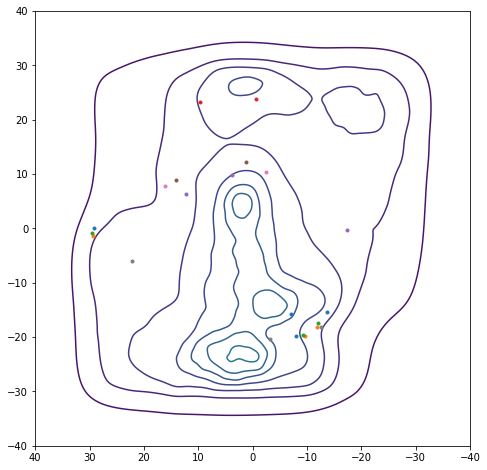

In [5]:
plt.figure(figsize=(8,8))
plotutil.plotDensityContours(li, densityUnit=sigmaCrit, levels=np.arange(0.2, 4, 0.2))
plt.gca().invert_xaxis()
plotutil.plotImagesData(imgList)

In [6]:
subLenses = [ x["lens"] for x in lens.getLensParameters() ]

In [7]:
liCache = {}

In [8]:
def getLI(lens):
    h = hashlib.sha224(lens.toBytes()).hexdigest()
    if not h in liCache:
        liCache[h] = plotutil.LensInfo(lens, size=80*ANGLE_ARCSEC, zd=zd, zs=zs) 
    return liCache[h]

In [9]:
ctr = [0,0*ANGLE_ARCSEC]
radius = 26*ANGLE_ARCSEC
profiles = []
thetas = None
for l in subLenses:
    thetas,p = plotutil.plotAverageDensityProfile(getLI(l), radius, ctr, axes=False)
    profiles.append(p)

profiles = np.array(profiles)

In [10]:
avgProf = np.average(profiles,0)
stdProf = np.std(profiles,0)

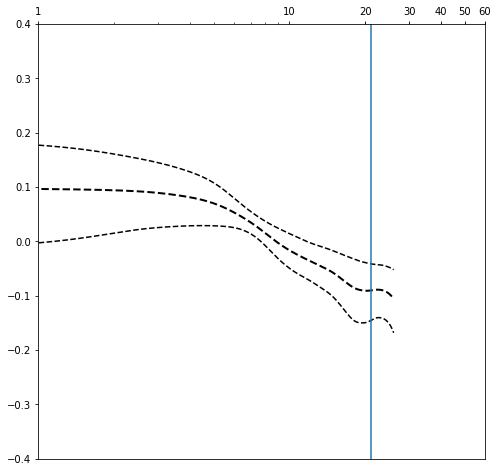

In [11]:
kpcPerArcsec = cosm.getAngularDiameterDistance(zd)*ANGLE_ARCSEC/DIST_KPC

plt.figure(figsize=(8,8))
plt.plot(thetas/ANGLE_ARCSEC, np.log10(avgProf/sigmaCrit), '--', lw=2, color="black")
plt.plot(thetas/ANGLE_ARCSEC, np.log10((avgProf+stdProf)/sigmaCrit), '--', color="black")
plt.plot(thetas/ANGLE_ARCSEC, np.log10((avgProf-stdProf)/sigmaCrit), '--', color="black")
plt.xscale("log")
plt.gca().set_ylim([-0.4,0.4])
y0, y1 = plt.ylim()
plt.plot([100/kpcPerArcsec,100/kpcPerArcsec], [y0,y1])
plt.gca().set_xlim([1, 60])
tcks = [1,10,20,30,40,50,60]
plt.xticks(tcks,map(str,tcks))
plt.gca().xaxis.tick_top();